In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [62]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 10
batch_size = 5
learning_rate = 0.001

In [42]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [43]:
data_dir = 'Rice_Image_Dataset'
x = 'train'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])}
print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)}
dataset_sizes = {len(image_datasets[x])}
print(dataset_sizes)
class_names = image_datasets['train'].classes
#class_names = ('Arborio', 'Basmati', 'Ipsala','Jasmine','Karacadag')
print(class_names)

{'train': Dataset ImageFolder
    Number of datapoints: 75000
    Root location: Rice_Image_Dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )}
{75000}
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


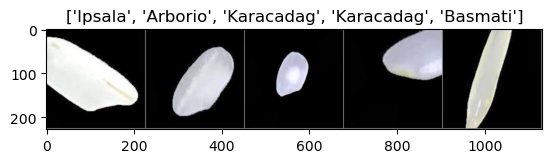

In [44]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [56]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 color channels input, 6 output size and 5 is kernel size
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        # input size must be equaled with the output size of conv1
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # output size * the size of image
        self.fc1 = nn.Linear(64*28*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    '''
    nn.Conv2d function:
    example: 5*5 input 3*3 filter padding=0 stride=1
    (W-F + 2*P)/S + 1
    (5-3 + 2*0)/1 +1 = 3 
    ->3*3

    pooling function:
    2*2 means 3*3/2 -> 1.5*1.5
    '''

    def forward(self, x):
        # -> n(batch size), 3(color channels), 32, 32(32*32 images)
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        #print(x.shape)  # 查看每一步的输出形状
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        #print(x.shape)  # 查看每一步的输出形状
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 16, 5, 5
        #print(x.shape)  # 查看每一步的输出形状
        # This reshapes the 4D tensor (n, 16, 5, 5) 
        # into a 2D tensor with shape (n, 400)
        # nn.Linear need a 2D tensor like (batch size, 16 * 5 * 5)
        x = x.view(-1, 64*28*28)            # -> n, 400
        #print(x.shape)  # 查看每一步的输出形状
        x = F.relu(self.fc1(x))               # -> n, 120
        #print(x.shape)  # 查看每一步的输出形状
        x = F.relu(self.fc2(x))               # -> n, 84
        #print(x.shape)  # 查看每一步的输出形状
        x = self.fc3(x)                       # -> n, 10
        #print(x.shape)  # 查看每一步的输出形状
        return x

In [57]:
model = ConvNet().to(device)
outputs = model(inputs)

In [63]:
model = ConvNet().to(device)
train_loader = dataloaders['train']

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [2000/15000], Loss: 1.4766
Epoch [1/10], Step [4000/15000], Loss: 0.9469
Epoch [1/10], Step [6000/15000], Loss: 0.4890
Epoch [1/10], Step [8000/15000], Loss: 0.2134
Epoch [1/10], Step [10000/15000], Loss: 0.3755
Epoch [1/10], Step [12000/15000], Loss: 0.2788
Epoch [1/10], Step [14000/15000], Loss: 0.3092
Epoch [2/10], Step [2000/15000], Loss: 0.5032
Epoch [2/10], Step [4000/15000], Loss: 0.3608
Epoch [2/10], Step [6000/15000], Loss: 0.1960
Epoch [2/10], Step [8000/15000], Loss: 0.2757
Epoch [2/10], Step [10000/15000], Loss: 0.1764
Epoch [2/10], Step [12000/15000], Loss: 1.3399
Epoch [2/10], Step [14000/15000], Loss: 0.1093
Epoch [3/10], Step [2000/15000], Loss: 0.3073
Epoch [3/10], Step [4000/15000], Loss: 1.4412
Epoch [3/10], Step [6000/15000], Loss: 0.8262
Epoch [3/10], Step [8000/15000], Loss: 0.0179
Epoch [3/10], Step [10000/15000], Loss: 0.4423
Epoch [3/10], Step [12000/15000], Loss: 0.3896
Epoch [3/10], Step [14000/15000], Loss: 0.8225
Epoch [4/10], Step [2000/

"\nprint('Finished Training')\nPATH = './cnn.pth'\ntorch.save(model.state_dict(), PATH)\n\nwith torch.no_grad():\n    n_correct = 0\n    n_samples = 0\n    n_class_correct = [0 for i in range(10)]\n    n_class_samples = [0 for i in range(10)]\n    for images, labels in test_loader:\n        images = images.to(device)\n        labels = labels.to(device)\n        outputs = model(images)\n        # max returns (value ,index)\n        _, predicted = torch.max(outputs, 1)\n        n_samples += labels.size(0)\n        n_correct += (predicted == labels).sum().item()\n        \n        for i in range(batch_size):\n            label = labels[i]\n            pred = predicted[i]\n            if (label == pred):\n                n_class_correct[label] += 1\n            n_class_samples[label] += 1\n\n    acc = 100.0 * n_correct / n_samples\n    print(f'Accuracy of the network: {acc} %')\n\n    for i in range(10):\n        acc = 100.0 * n_class_correct[i] / n_class_samples[i]\n        print(f'Accura

In [66]:

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)




Finished Training
Accuracy of the network: 96.04933333333334 %
Accuracy of 2: 92.96 %
Accuracy of 0: 96.88 %
Accuracy of 4: 99.41333333333333 %
Accuracy of 4: 95.52666666666667 %
Accuracy of 1: 95.46666666666667 %


In [67]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {class_names[i]}: {acc} %')

Accuracy of the network: 95.968 %
Accuracy of Arborio: 92.84666666666666 %
Accuracy of Basmati: 96.36666666666666 %
Accuracy of Ipsala: 99.42 %
Accuracy of Jasmine: 95.60666666666667 %
Accuracy of Karacadag: 95.6 %
